In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import os
import pickle
from collections import Counter
from gensim import corpora, models
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid")
import itertools

import warnings
warnings.filterwarnings('ignore')

#GLOBAL VARIABLES
Path='../data/'
models='../data/models/'

# T-SNE && UMAP && embeddings

In [19]:
fname='df_metacyc_multilabel.pkl'
dataM=pickle.load(open(Path+fname,'rb'))
dataM.head()

fname='df_kegg.pkl'
dataK=pickle.load(open(Path+fname,'rb'))
dataK.head()

EC=dataM.EC.to_list() +dataK.EC.to_list()

In [33]:
def FT(epoch,EC_lists,negative,min_n):
    model_gensim = FT_gensim(size=300)
    model_gensim.build_vocab(sentences=EC_lists,min_count=1)
    model_gensim.train(EC_lists, total_examples=len(EC_lists), epochs=epoch,min_n=3,window=5,sg=1,negative=negative)
    return model_gensim

def plot_umap(cluster_df,model_gensim,title_text):
    keys=['Degradation','Biosynthesis','Energy','Activation','Glycan','Macromolecule','Detoxification']
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    for m,n in enumerate(keys):
        embeddings=[]
        labels=cluster_df[cluster_df[n]==1]#.value_counts()
        PWY=labels.EC_set.to_list()
        for l in PWY:
            embeddings.append(np.mean(model_gensim[l],axis=0))
        emb=np.array(embeddings)
        X_2d = umap.UMAP(random_state=42).fit_transform(emb)
        colors = 'r', 'g', 'b', 'orange', 'pink', 'm','purple','brown','y'
        ax1.scatter(X_2d[:, 0], X_2d[:, 1],c=colors[m],s=200,edgecolor='gray',label=keys[m])
    plt.xlabel('Dimension #1',size=16)
    plt.ylabel('Dimension #2',size=16)
    plt.grid(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
    #plt.legend()
    #plt.title(title_text,size=16)
    ax1.tick_params(axis='both', which='major', labelsize=0)
    plt.show()
    
    
def plot_umap_kegg(cluster_df,model_gensim):
    keys=['Amino-acid-metabolism',
 'Biosynthesis-of-other-secondary-metabolites',
 'Carbohydrate-metabolism',
 'Energy-metabolism',
 'Glycan-biosynthesis-and-metabolism',
 'Lipid-metabolism',
 'Metabolism-of-cofactors-and-vitamins',
 'Metabolism-of-other-amino-acids',
 'Metabolism-of-terpenoids-and-polyketides',
 'Xenobiotics-biodegradation-and-metabolism']

    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    for m,n in enumerate(keys):
        embeddings=[]
        labels=cluster_df[cluster_df['Label Name']==n]#.value_counts()
        PWY=labels.EC_set.to_list()
        for l in PWY:
            embeddings.append(np.mean(model_gensim[l],axis=0))
        emb=np.array(embeddings)
        X_2d = umap.UMAP(random_state=42).fit_transform(emb)
        colors = 'r', 'g', 'b', 'orange', 'pink', 'm','purple','y','red','blue','green','black'
        ax1.scatter(X_2d[:, 0], X_2d[:, 1],c=colors[m],s=200,edgecolor='gray',label=keys[m])
    plt.xlabel('Dimension #1',size=16)
    plt.ylabel('Dimension #2',size=16)
    plt.grid(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=12)
    #plt.legend()
    #plt.title(str(model_gensim),size=16)
    ax1.tick_params(axis='both', which='major', labelsize=0)
    plt.show()
    
def get_clusters(model_gensim,keys):
    embedding_clusters = []
    word_clusters=[]
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model_gensim.wv.most_similar(word, topn=100):
            words.append(similar_word)
            embeddings.append(model_gensim[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return word_clusters,embedding_clusters

def plot_umap_similar_words(labels, embedding_clusters, word_clusters):
    fig = plt.figure(figsize=(10, 7))
    ax = plt.subplot(111)
    colors = 'r', 'g', 'b', 'orange', 'pink', 'm','purple','brown'
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], label=label,s=300,edgecolor='gray',);
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Dimension #1',size=16)
    plt.ylabel('Dimension #2',size=16)
    plt.grid(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
    #plt.legend()
    #plt.title(str(model_gensim),size=16)
    ax.tick_params(axis='both', which='major', labelsize=0)
    plt.show()

def FT_ec_umap(model_gensim):
    keys=['ec:1','ec:2','ec:3','ec:4','ec:5','ec:6']
    word,embeddings=get_clusters(model_gensim,keys)
    embedding_clusters = np.array(embeddings)
    n, m, k = embedding_clusters.shape
    X_2d = np.array(umap.UMAP(random_state=42).fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n,m,2)
    plot_umap_similar_words(keys,X_2d, word)
    
def FT_ec_tsne(model_gensim):
    keys=['ec:1','ec:2','ec:3','ec:4','ec:5','ec:6']
    word,embeddings=get_clusters(model_gensim,keys)
    embedding_clusters = np.array(embeddings)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=25, n_components=2, init='pca', n_iter=5000, random_state=32)
    X_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    plot_umap_similar_words(keys,X_2d, word)
    
#    tsne_plot_similar_words('EC clusters: epochs '+str(epoch), keys, embeddings_en_2d, word, 0.2,
#                        'EC_clusters_'+str(epoch)+'.png')



Figure for model name model3-10-100


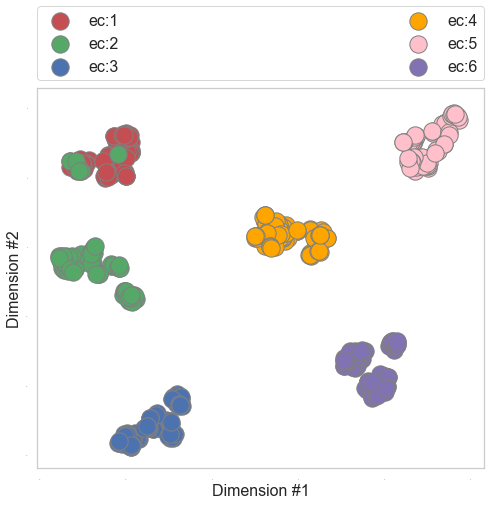

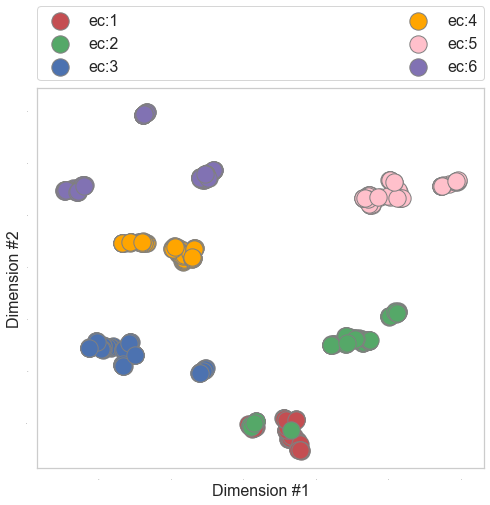

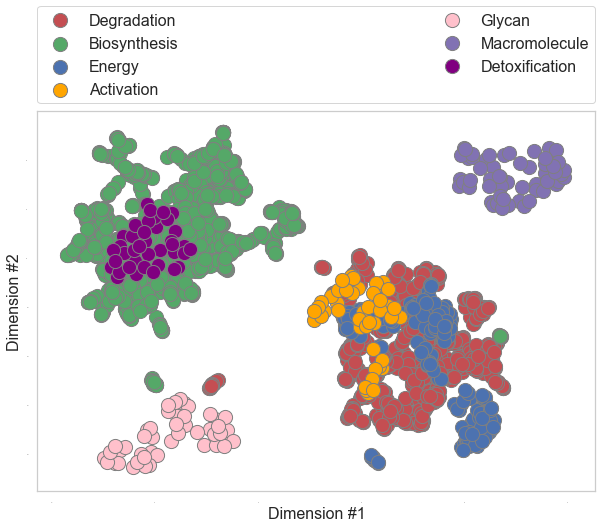

Figure for model name model3-10-200


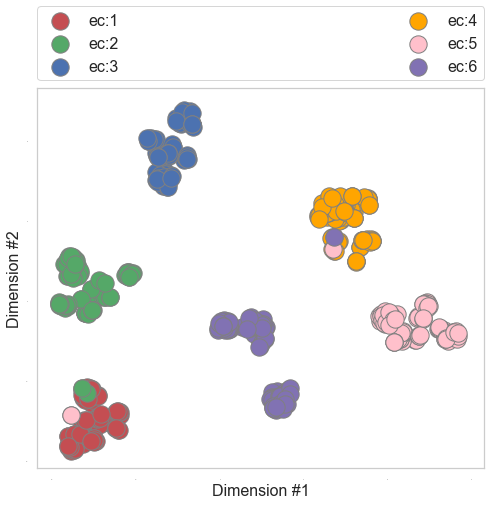

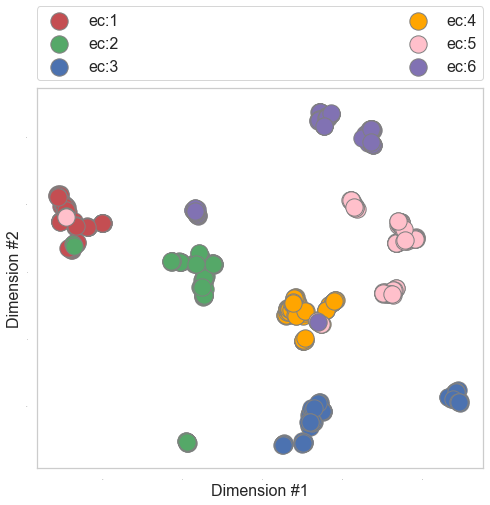

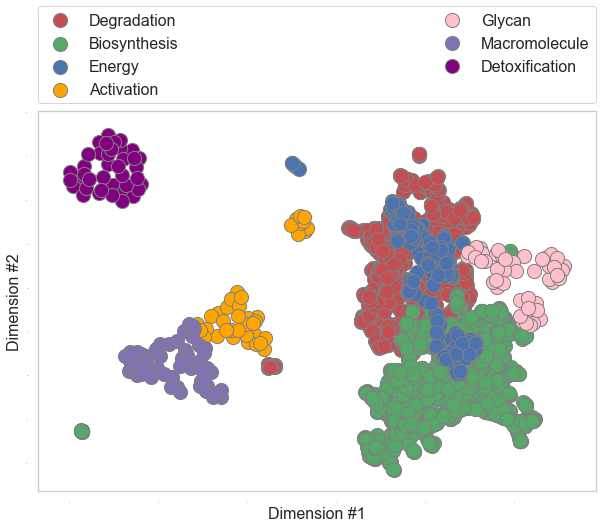

Figure for model name model3-10-300


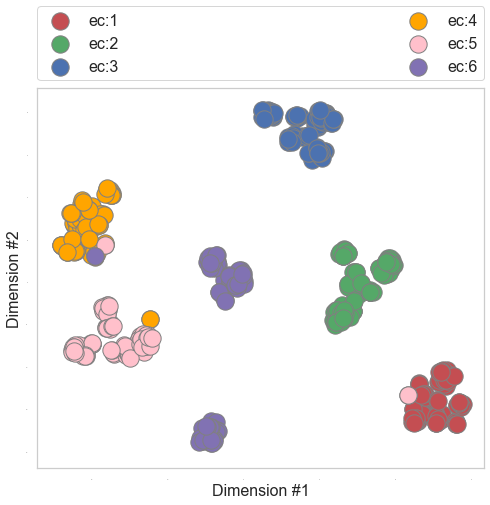

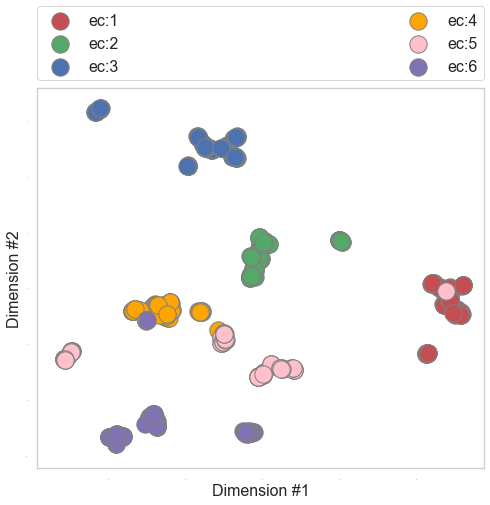

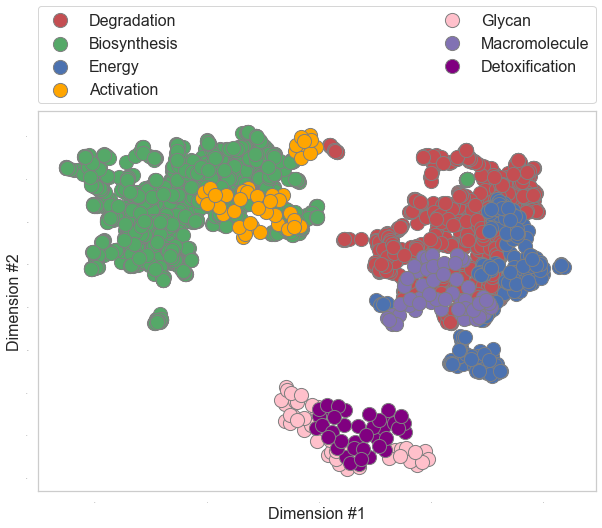

Figure for model name model3-100-100


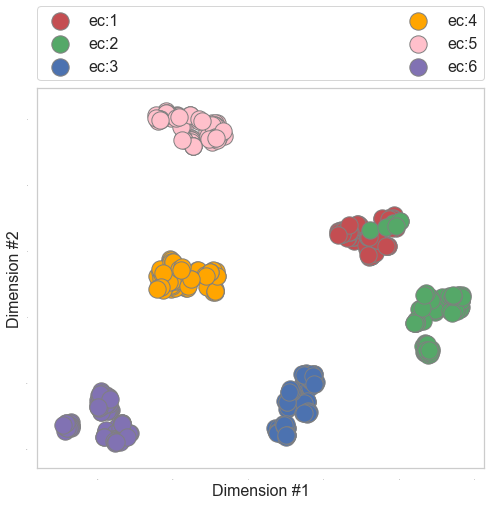

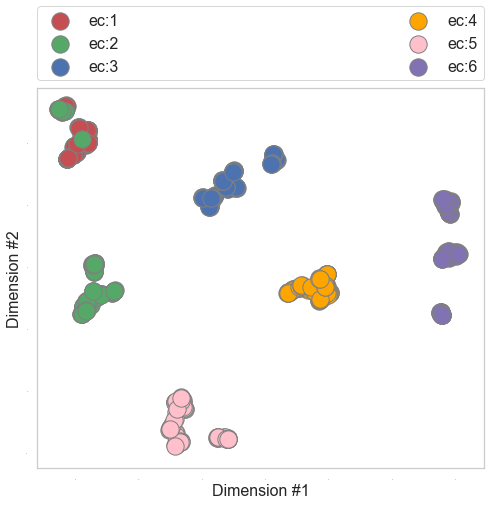

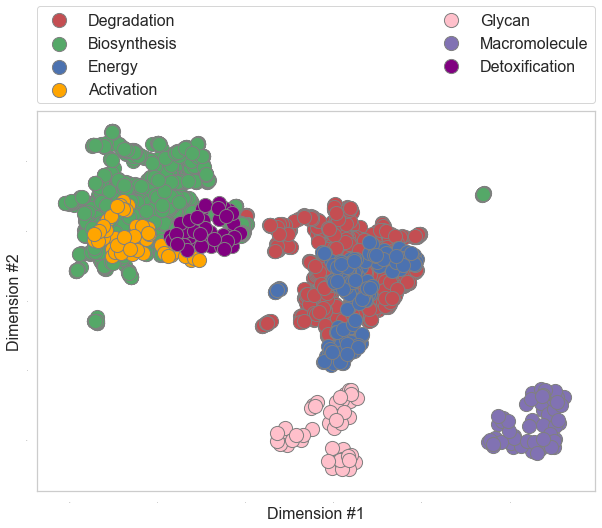

Figure for model name model3-100-200


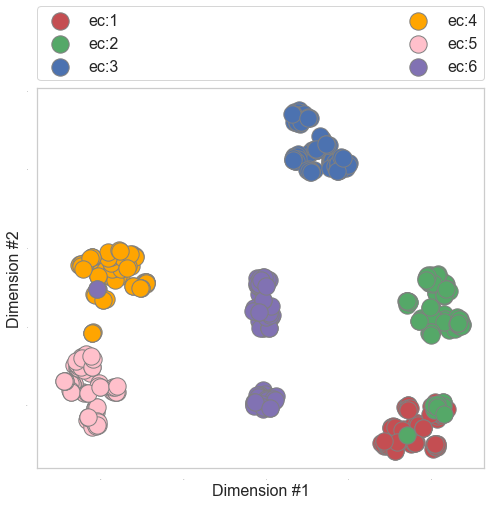

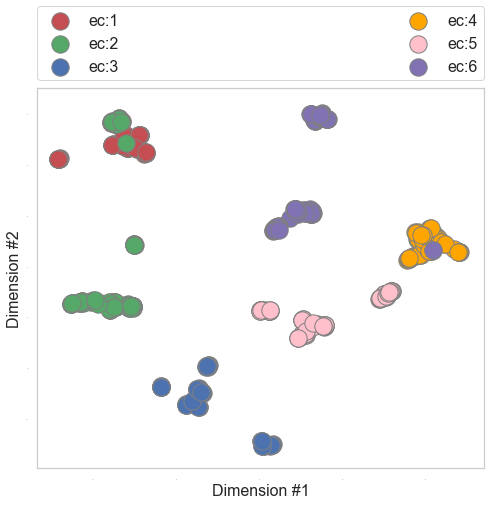

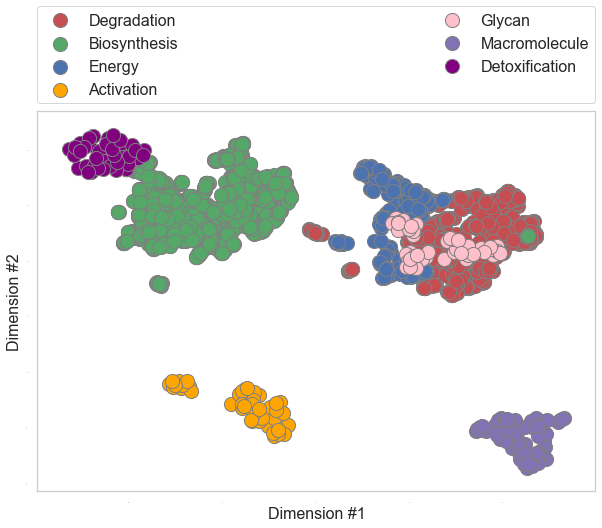

Figure for model name model3-100-300


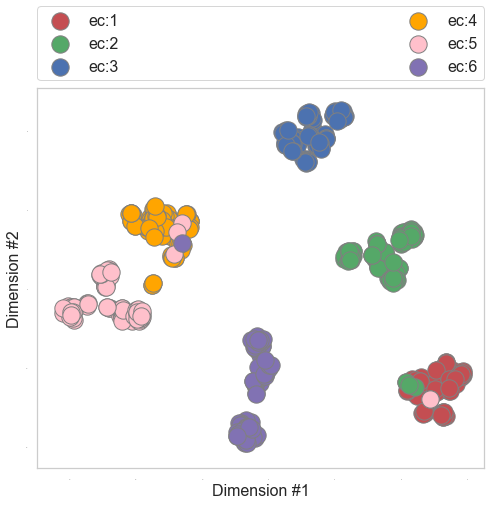

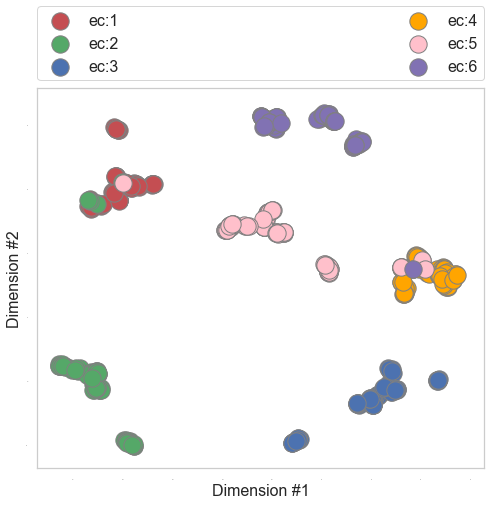

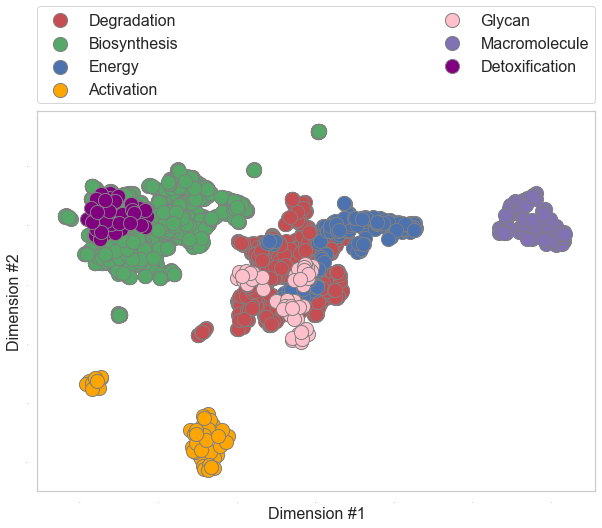

Figure for model name model3-1000-100


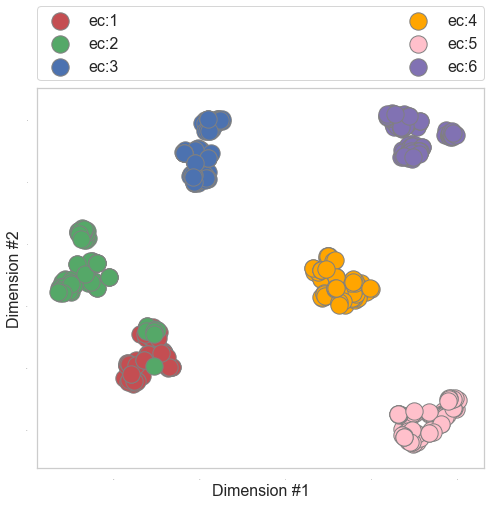

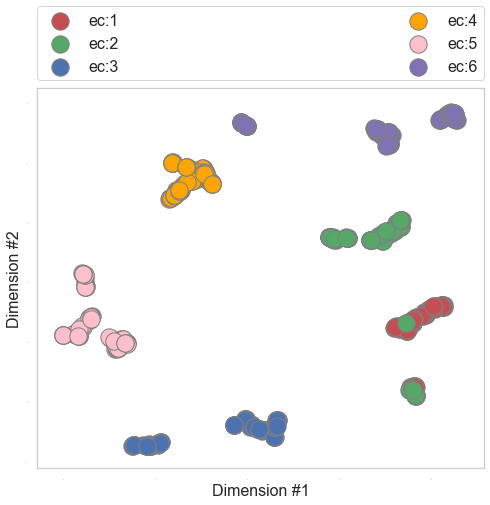

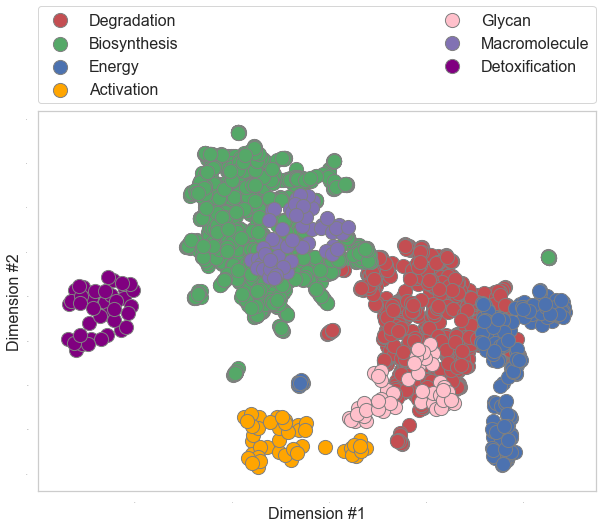

Figure for model name model3-1000-200


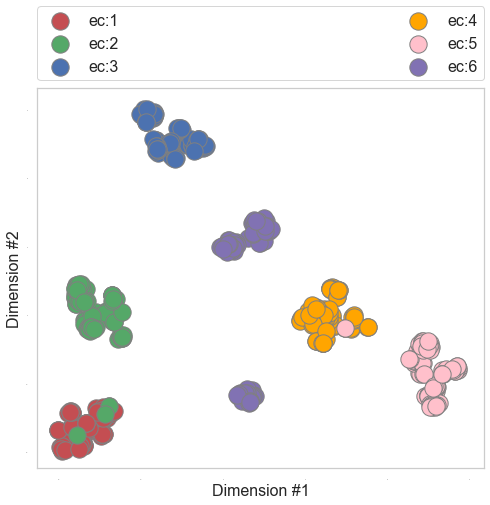

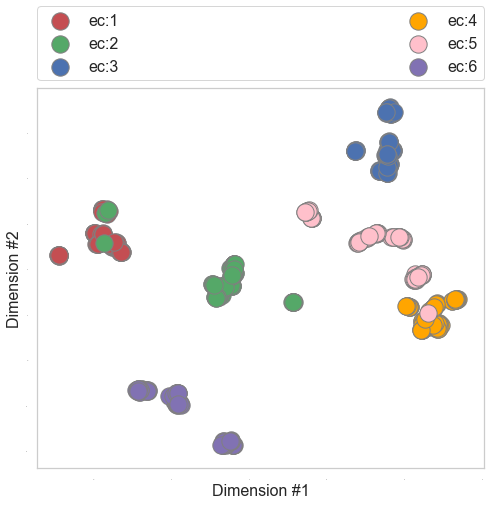

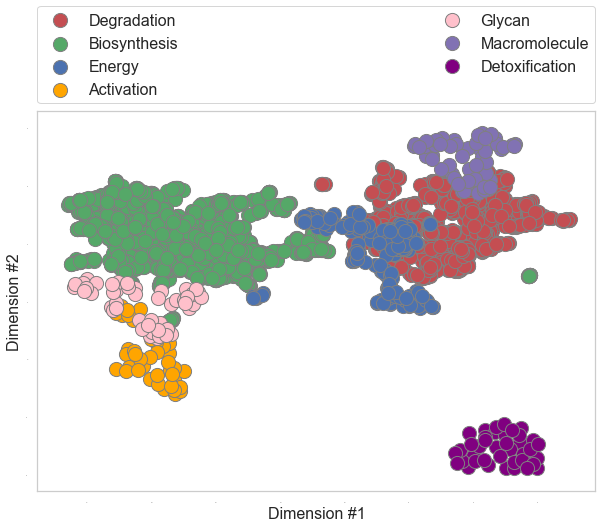

Figure for model name model3-1000-300


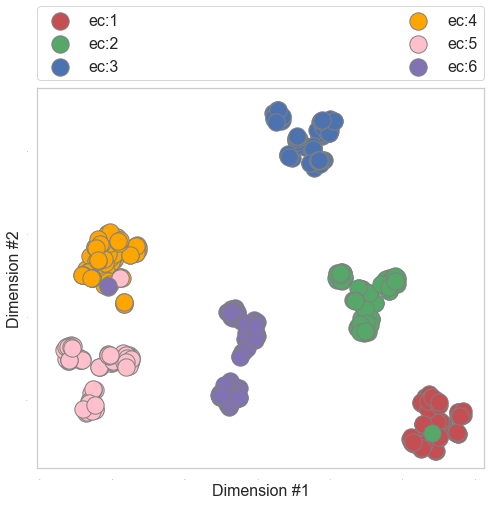

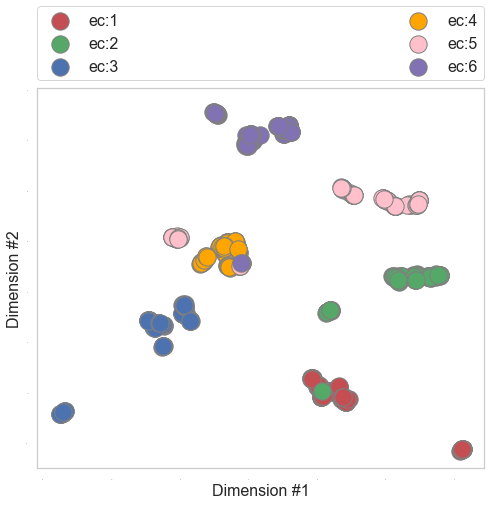

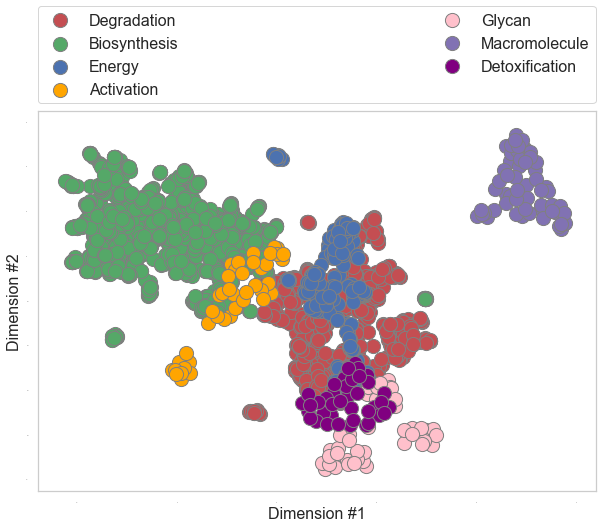

Figure for model name model4-10-100


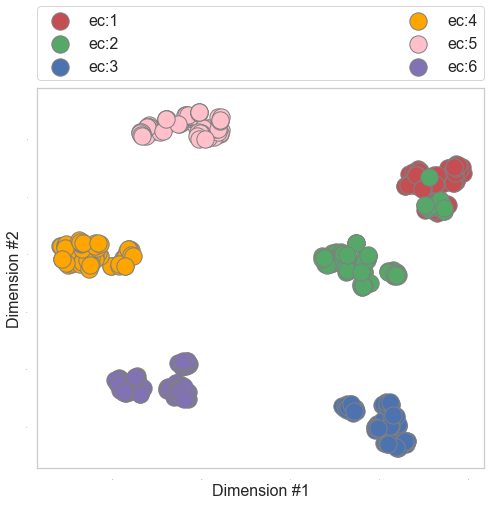

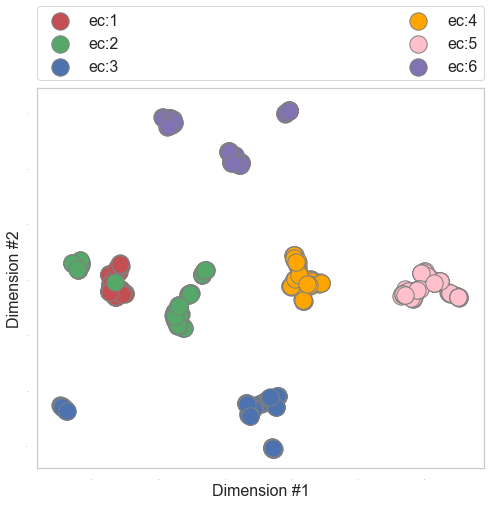

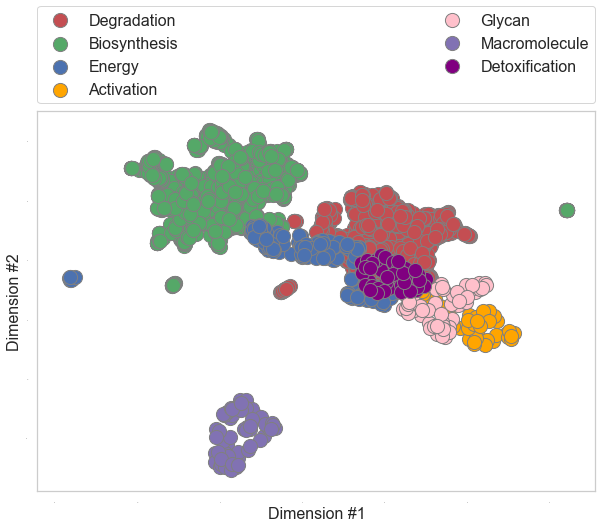

Figure for model name model4-10-200


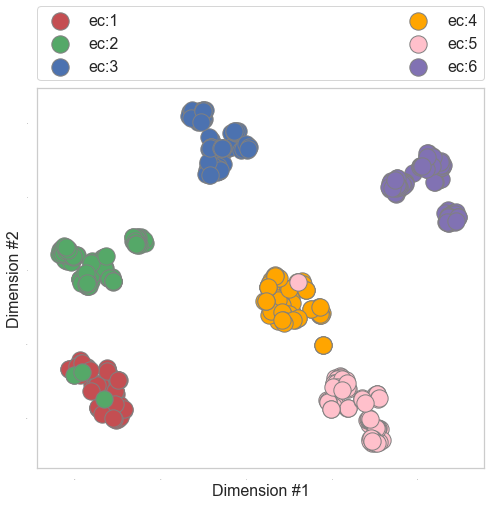

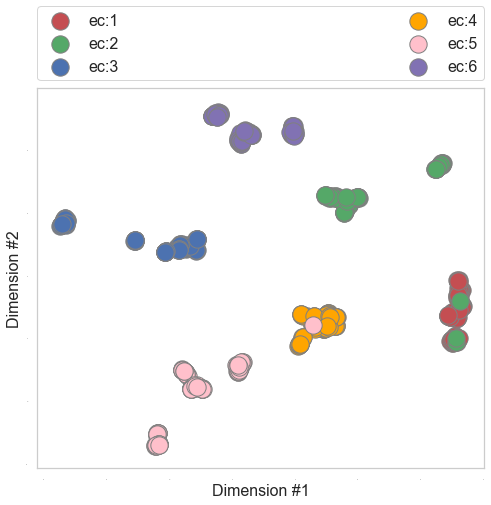

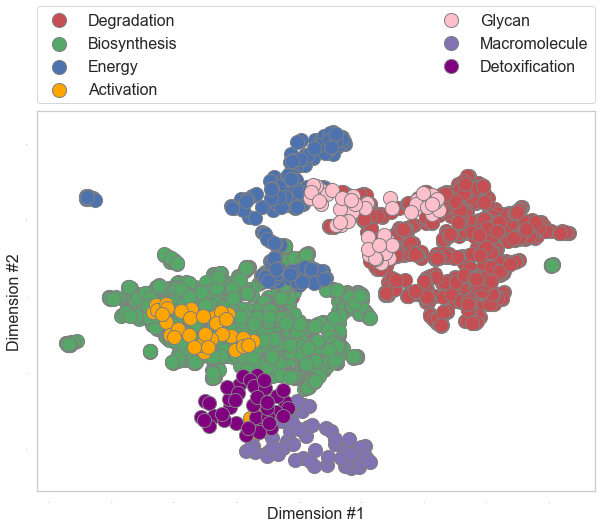

Figure for model name model4-10-300


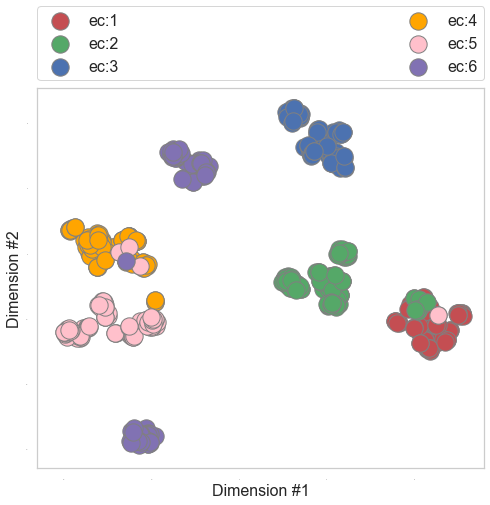

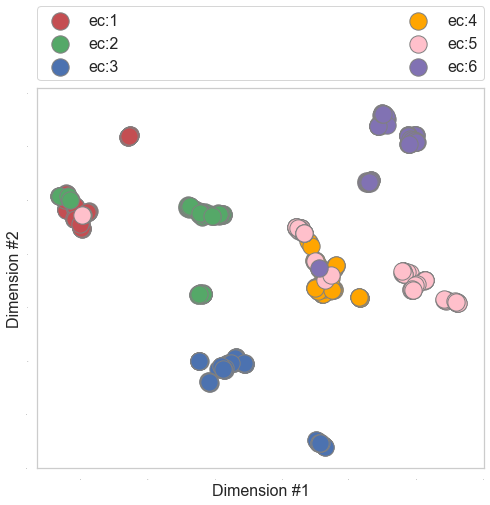

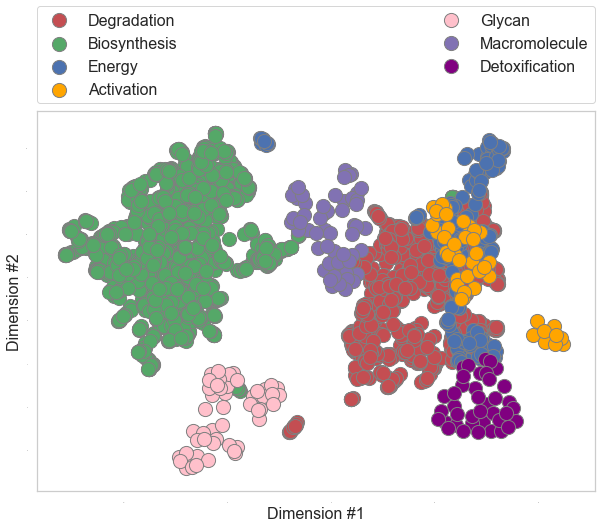

Figure for model name model4-100-100


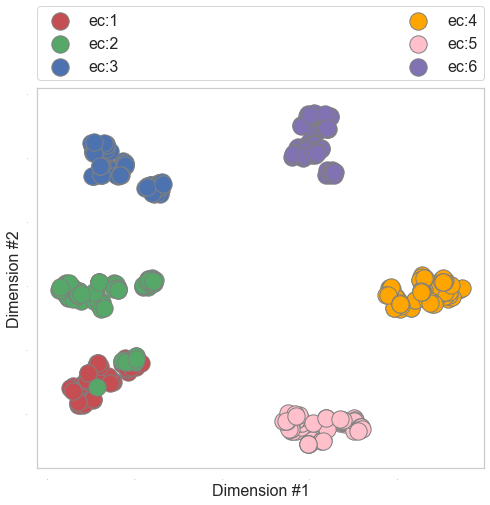

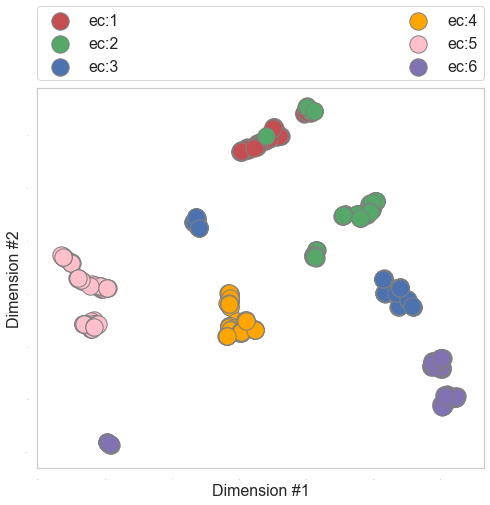

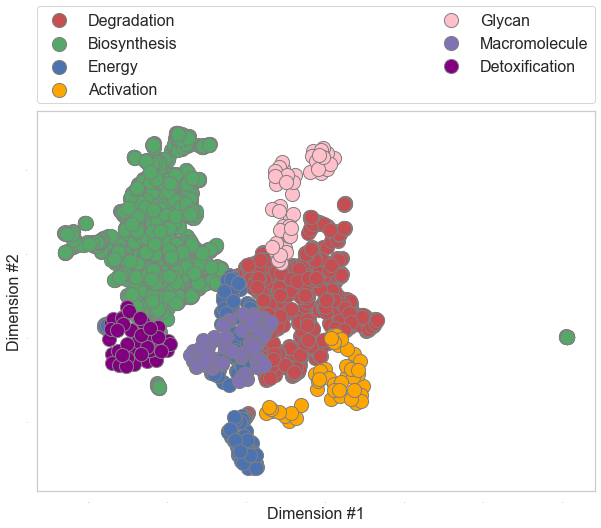

Figure for model name model4-100-200


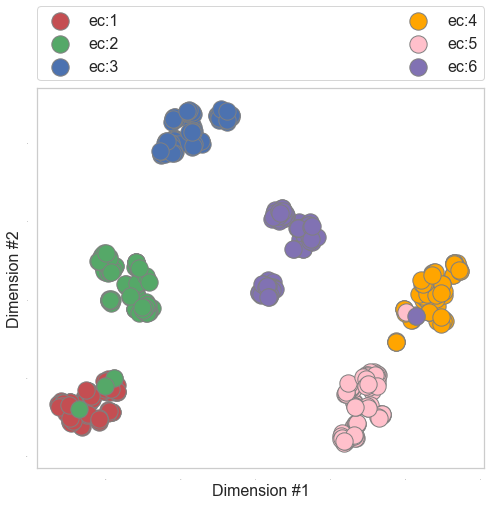

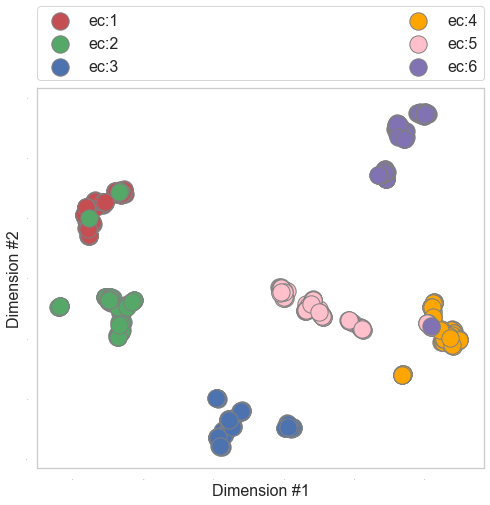

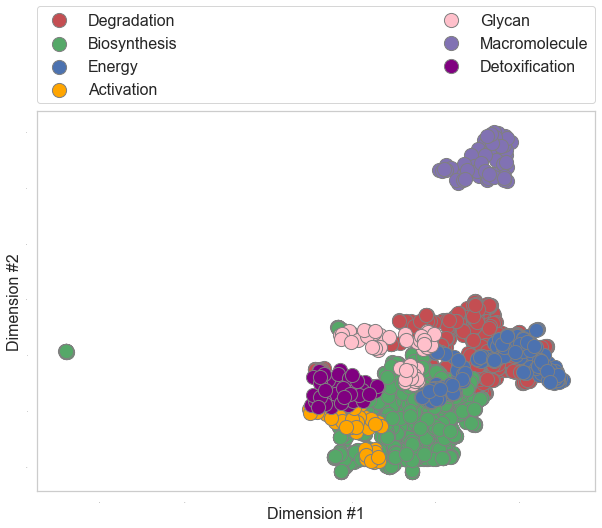

Figure for model name model4-100-300


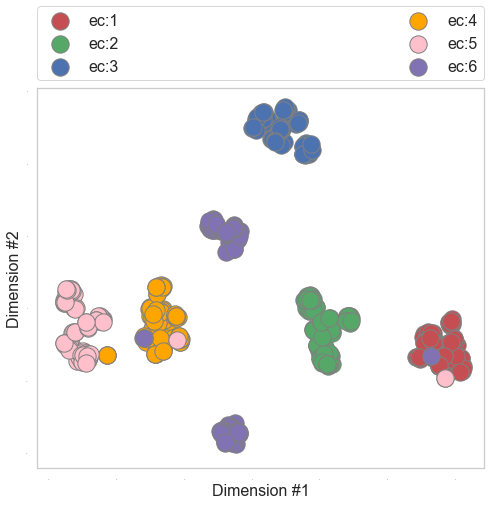

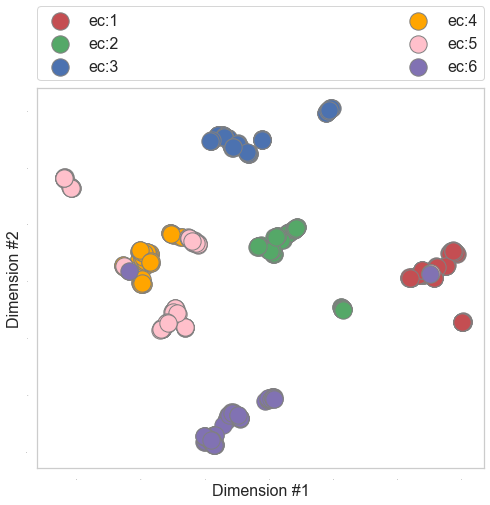

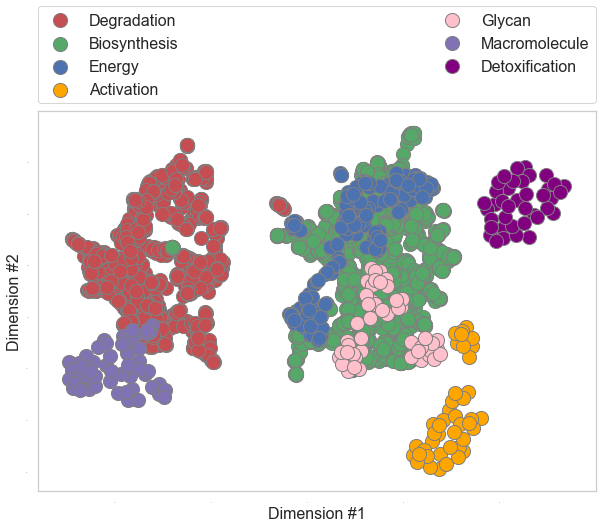

Figure for model name model4-1000-100


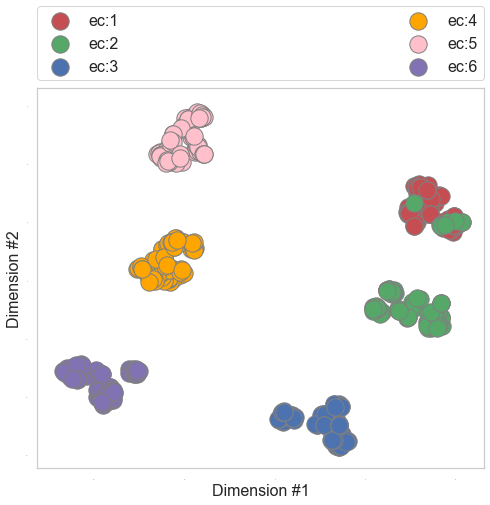

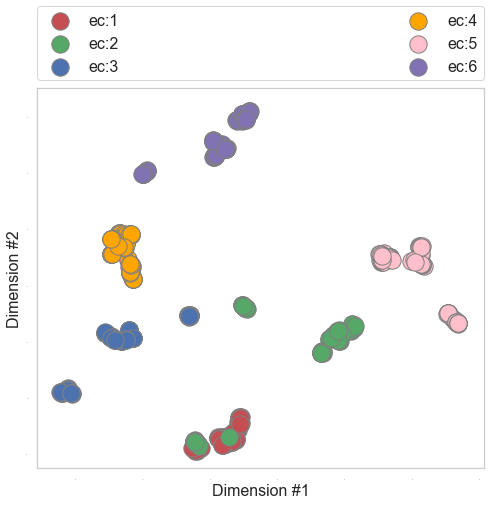

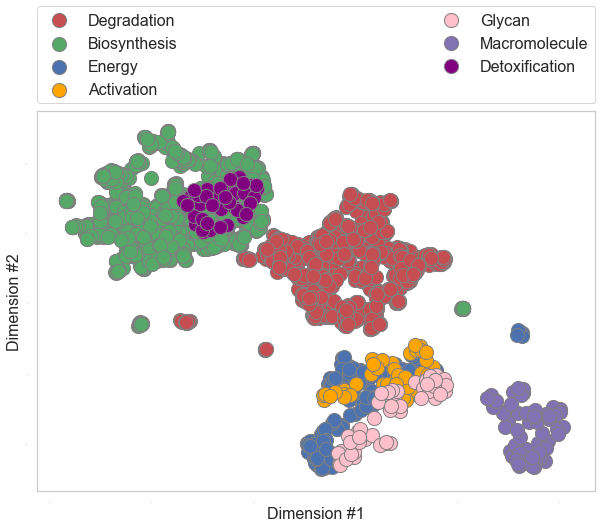

Figure for model name model4-1000-200


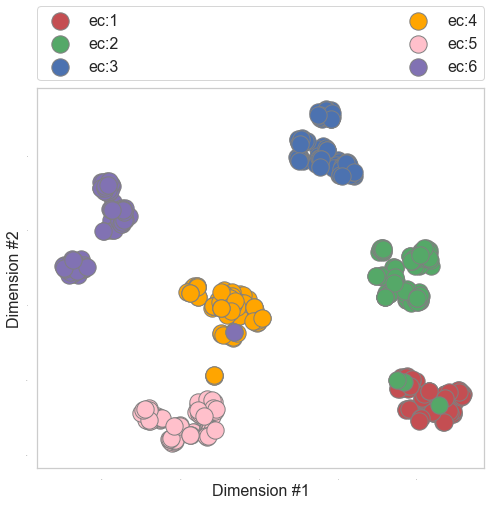

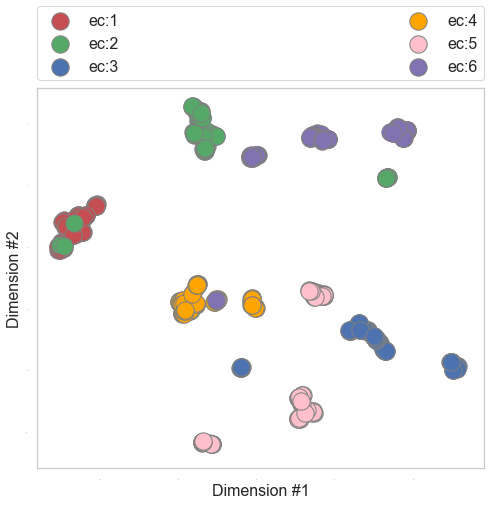

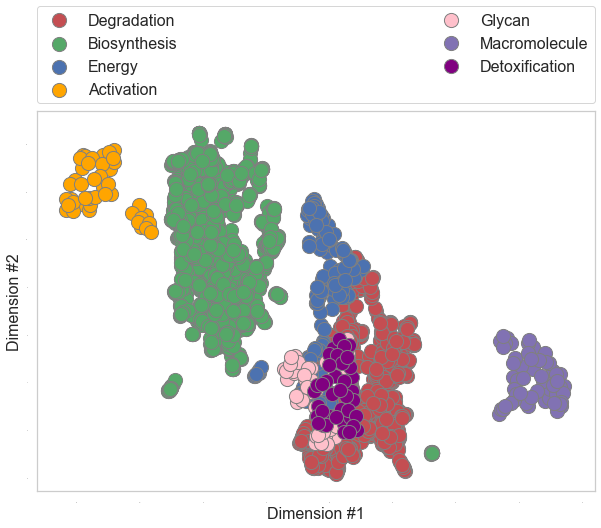

Figure for model name model4-1000-300


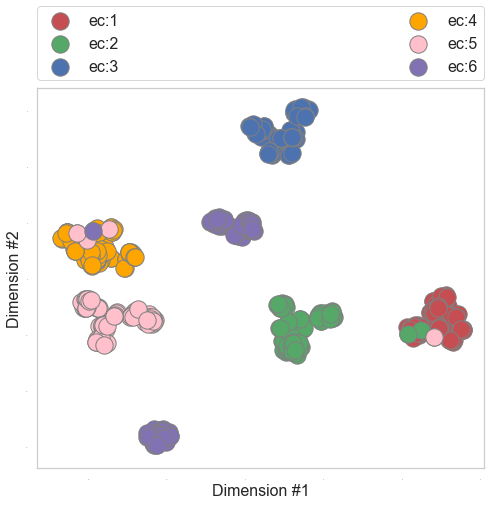

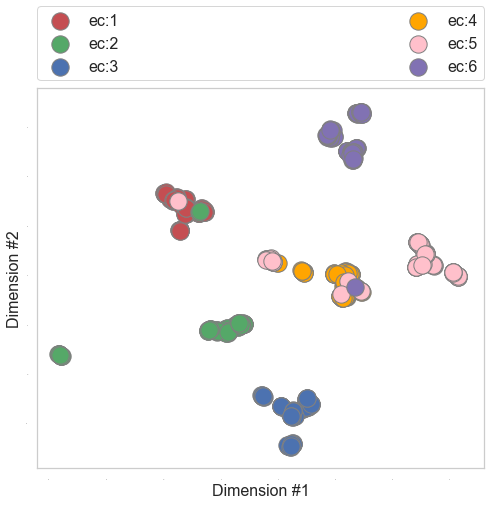

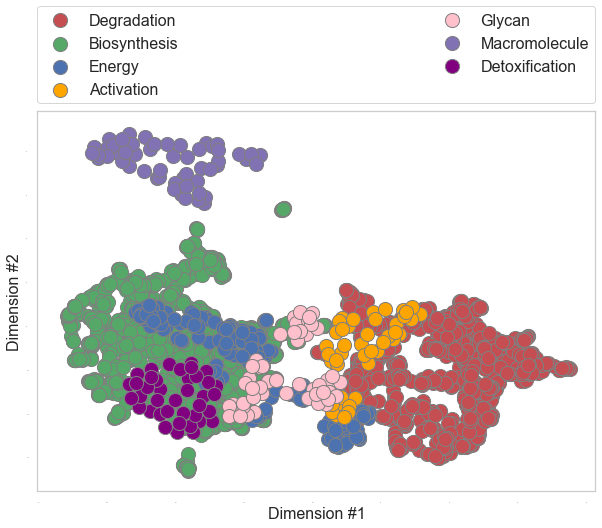

Figure for model name model5-10-100


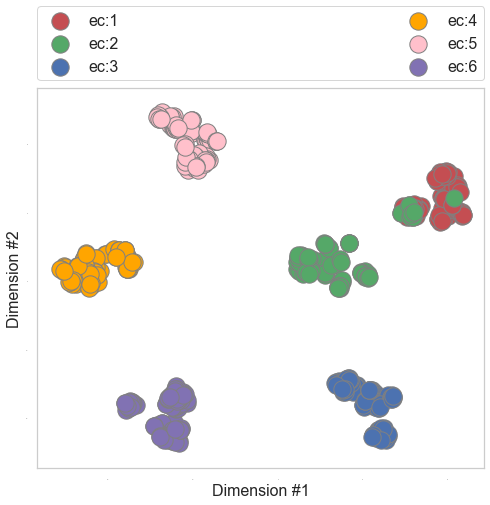

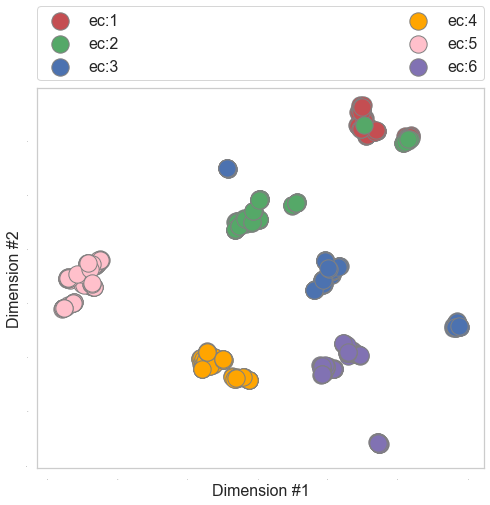

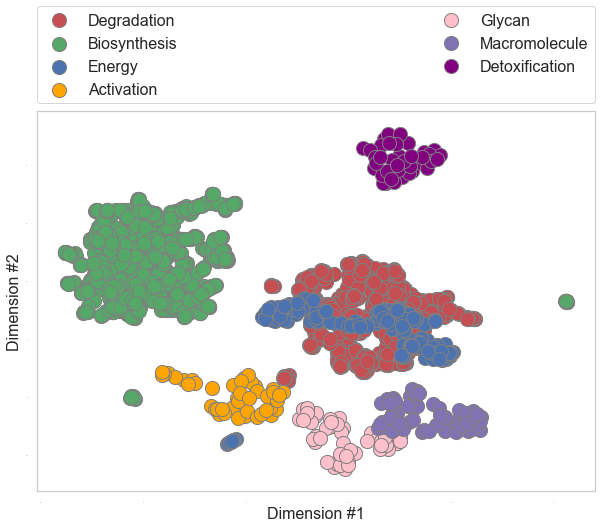

Figure for model name model5-10-200


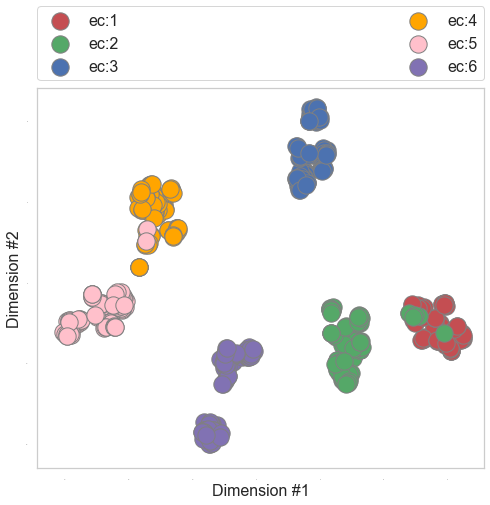

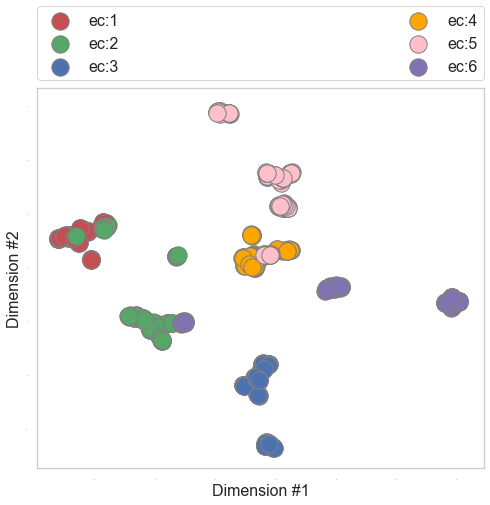

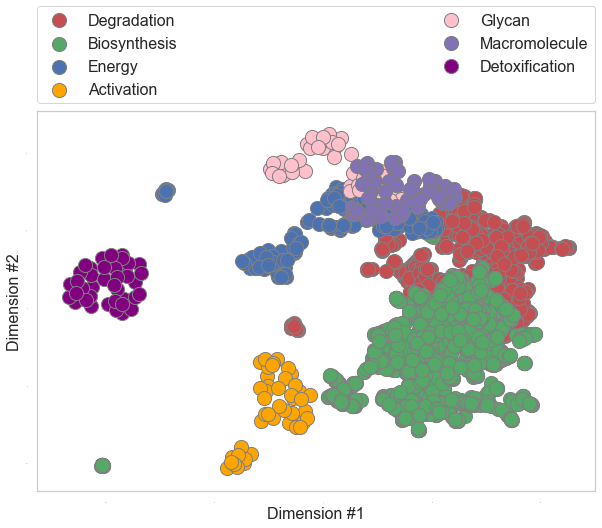

Figure for model name model5-10-300


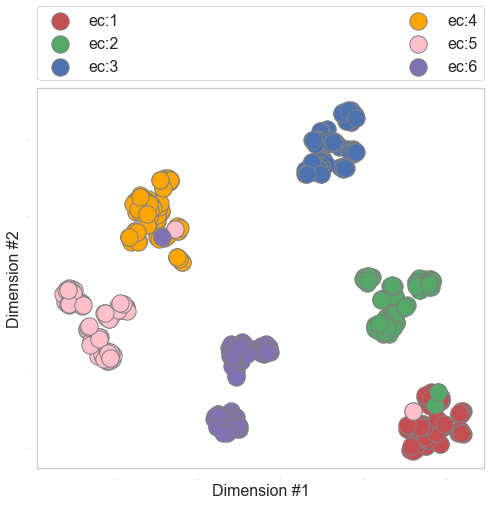

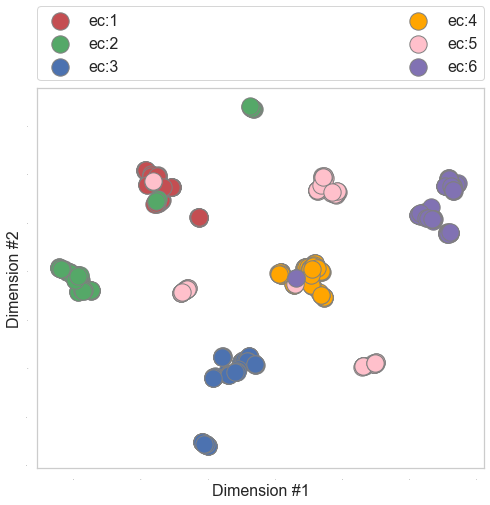

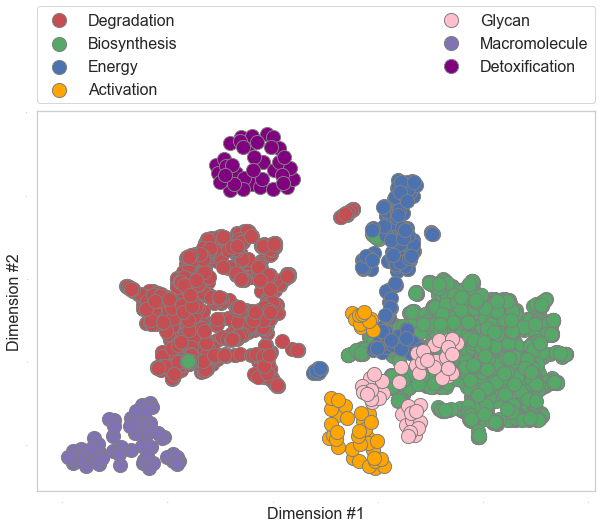

Figure for model name model5-100-100


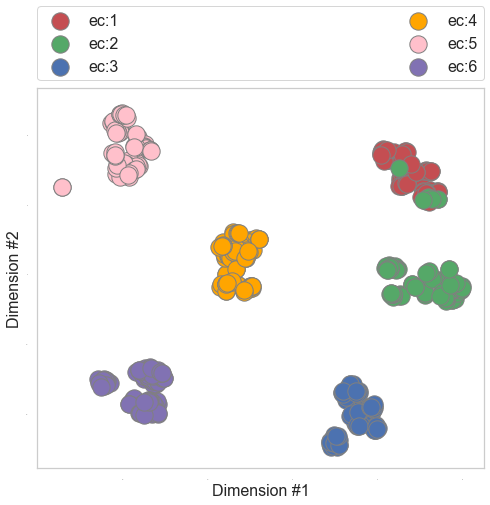

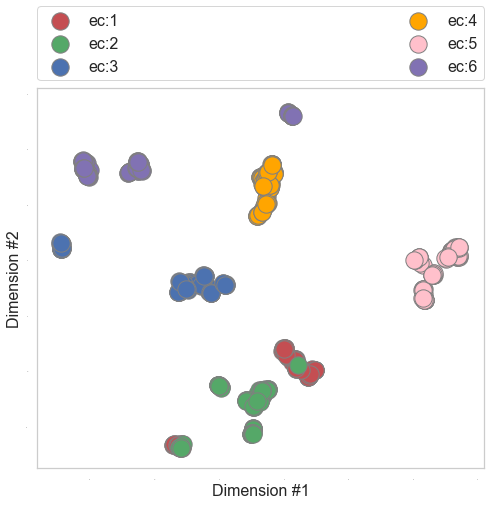

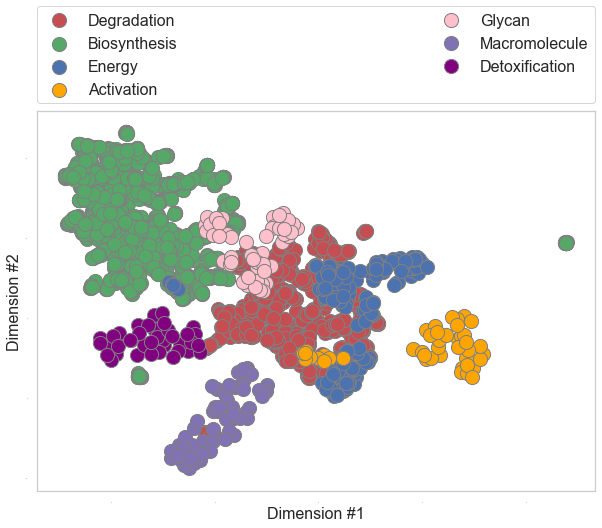

Figure for model name model5-100-200


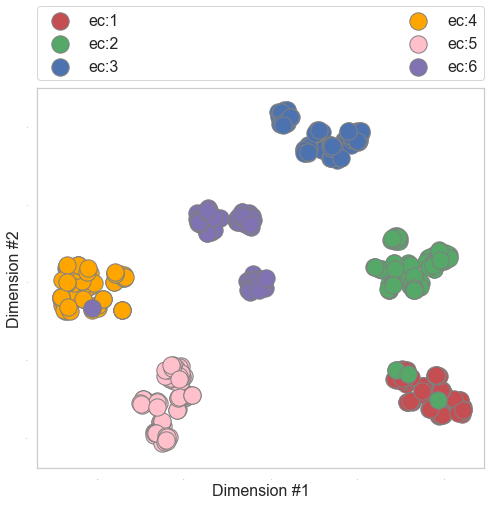

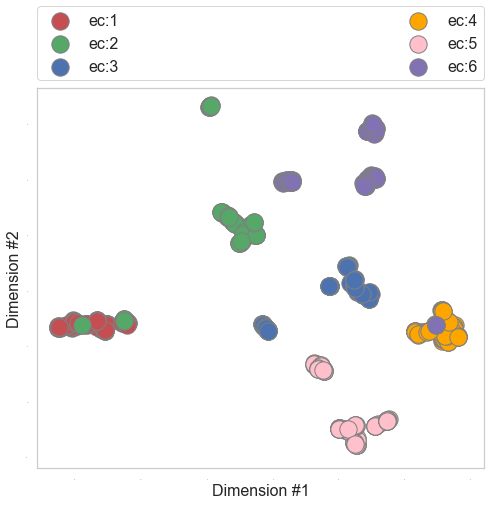

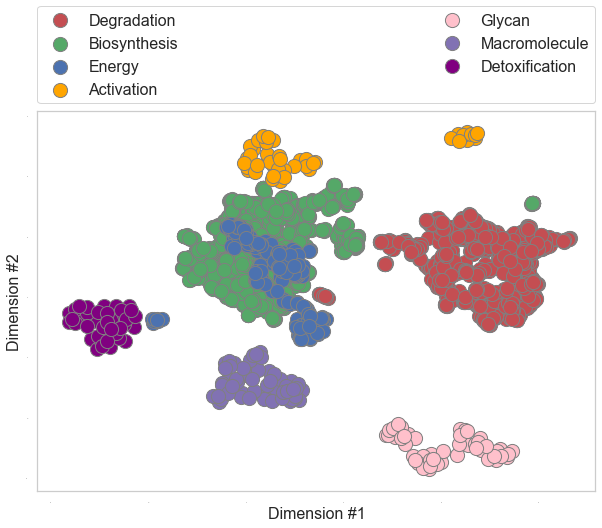

Figure for model name model5-100-300


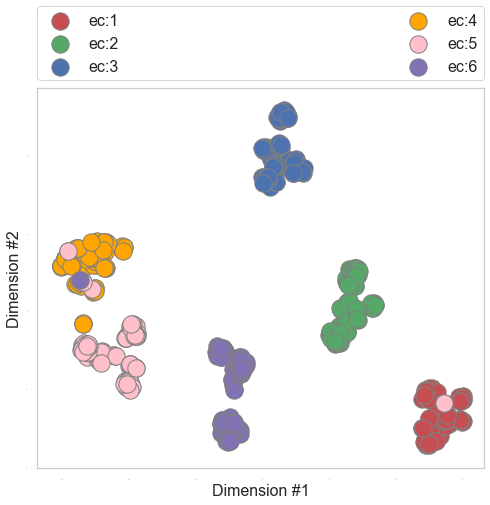

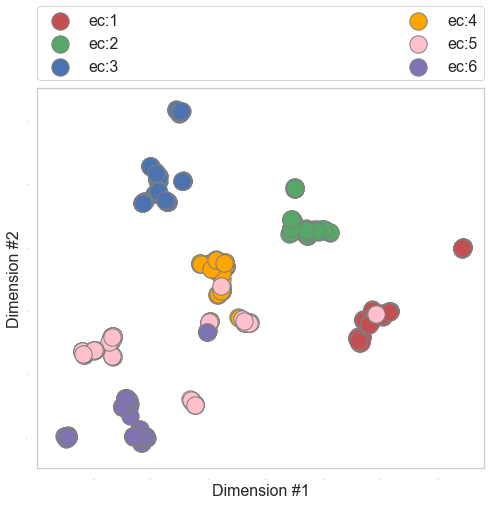

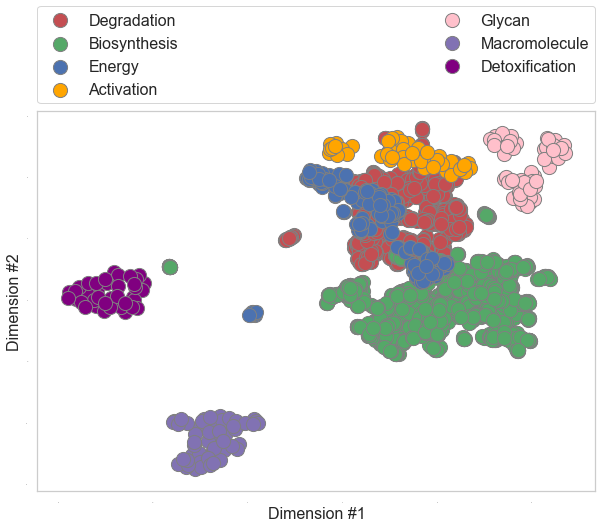

Figure for model name model5-1000-100


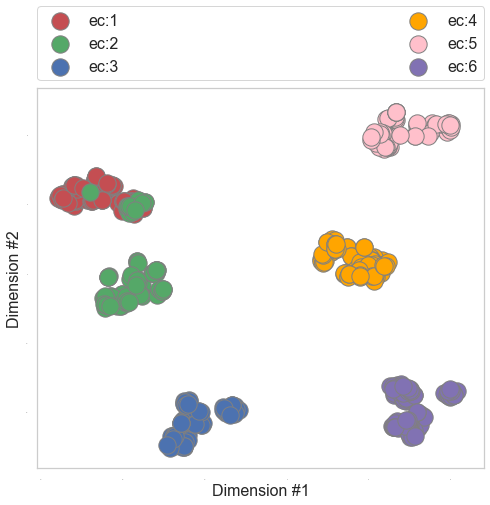

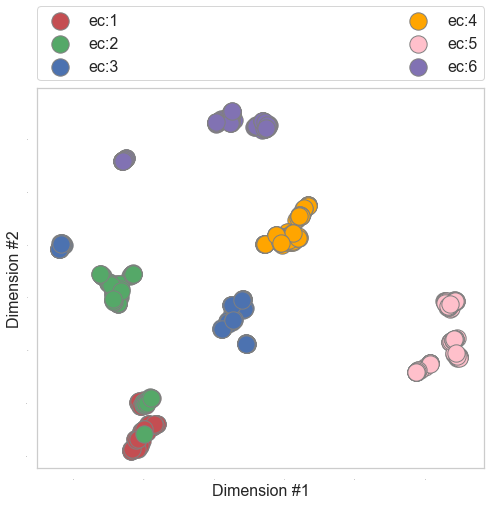

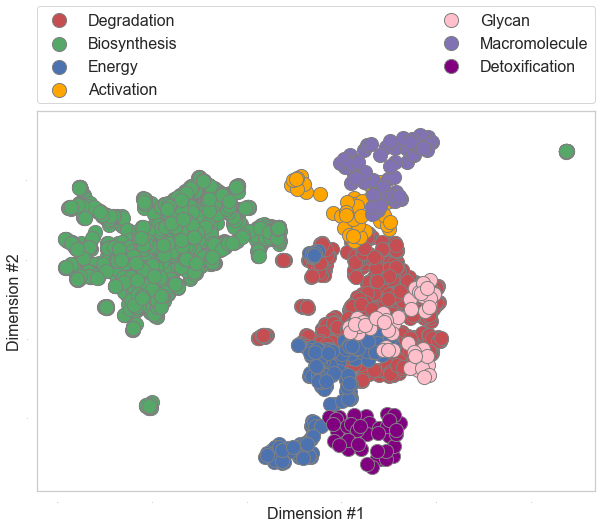

Figure for model name model5-1000-200


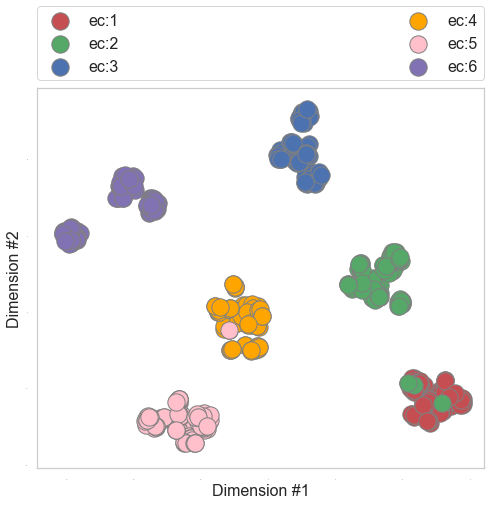

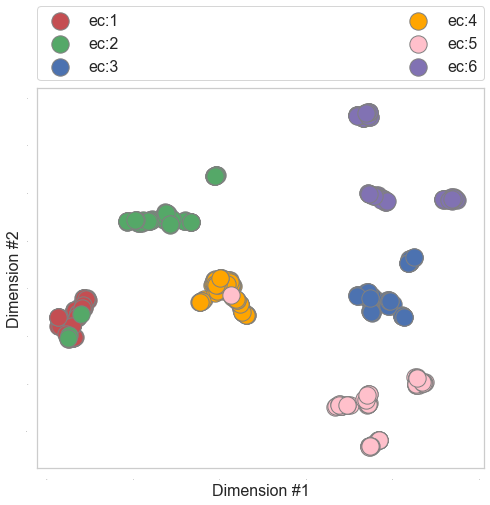

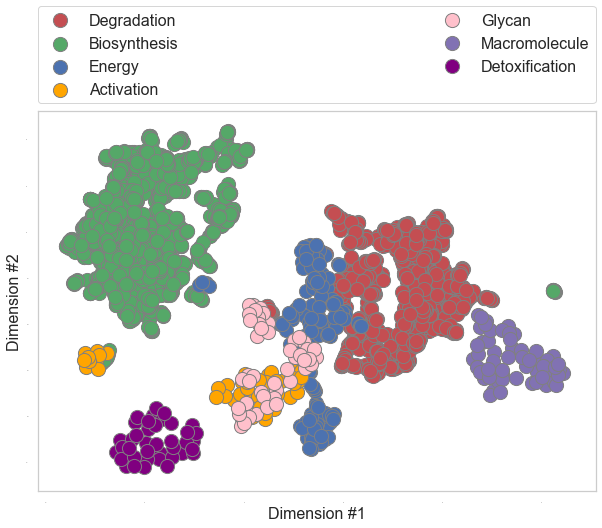

Figure for model name model5-1000-300


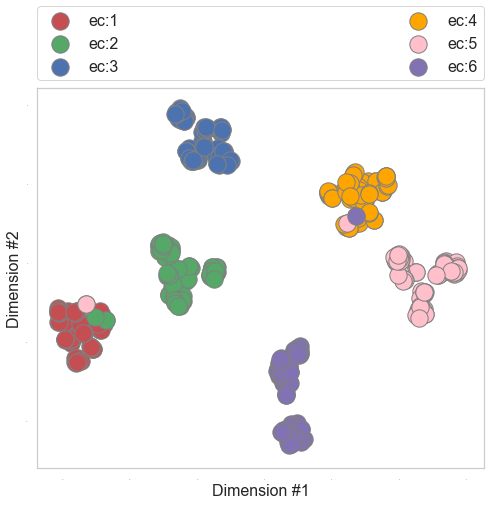

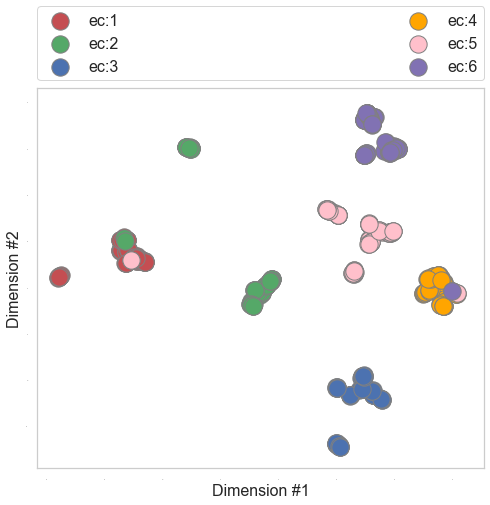

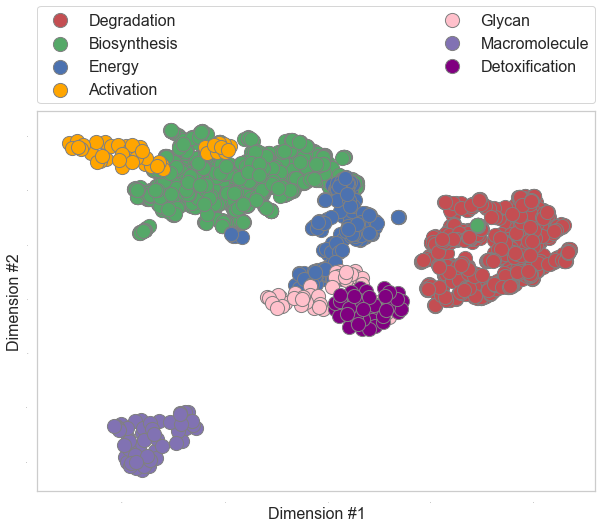

Figure for model name model6-10-100


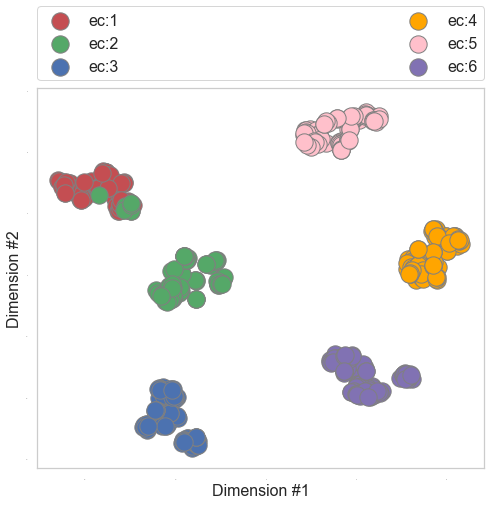

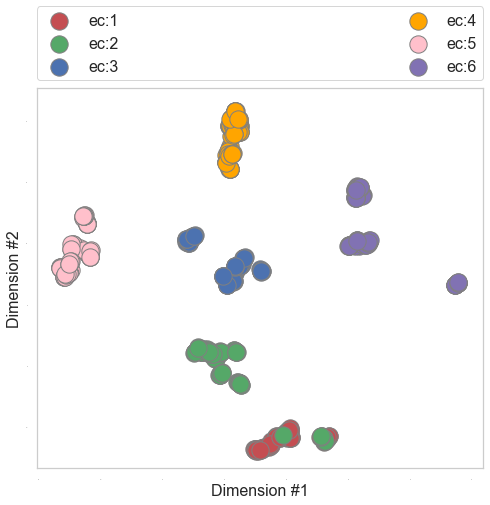

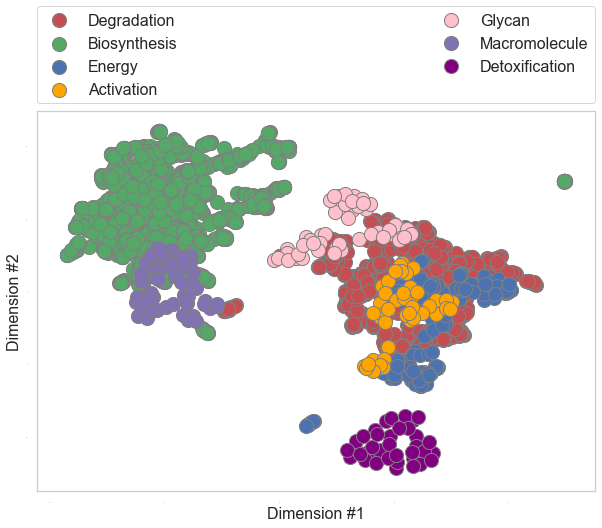

Figure for model name model6-10-200


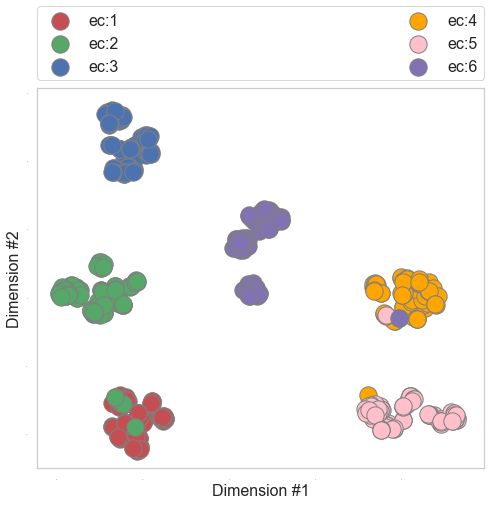

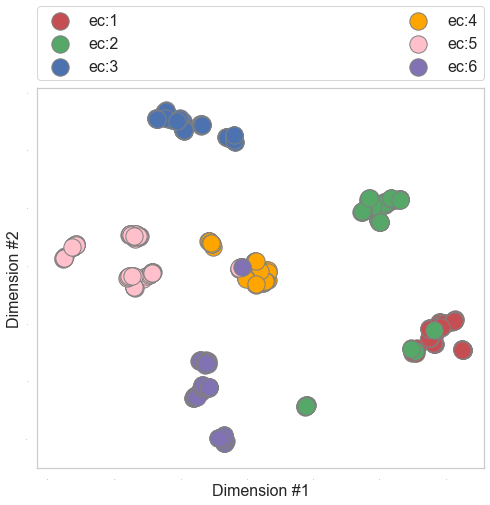

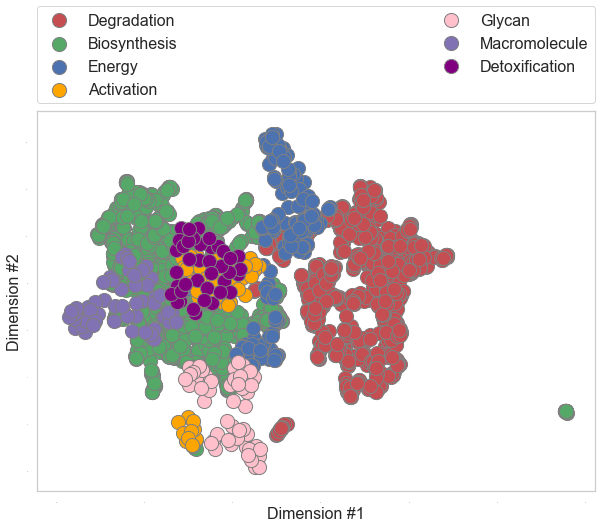

Figure for model name model6-10-300


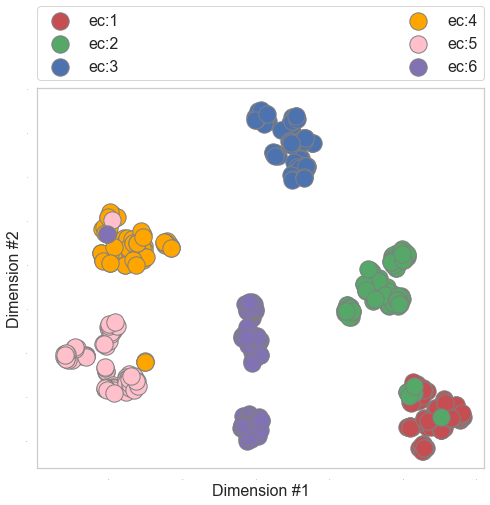

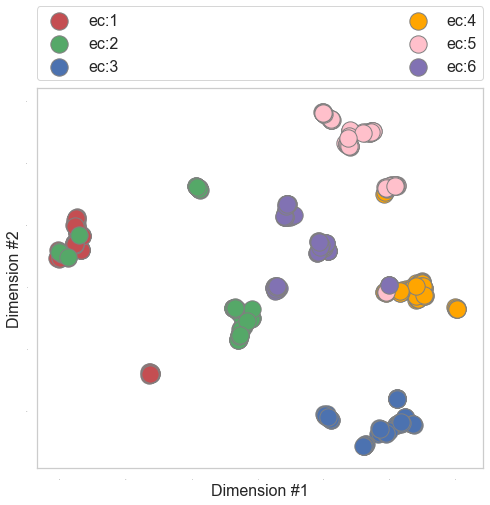

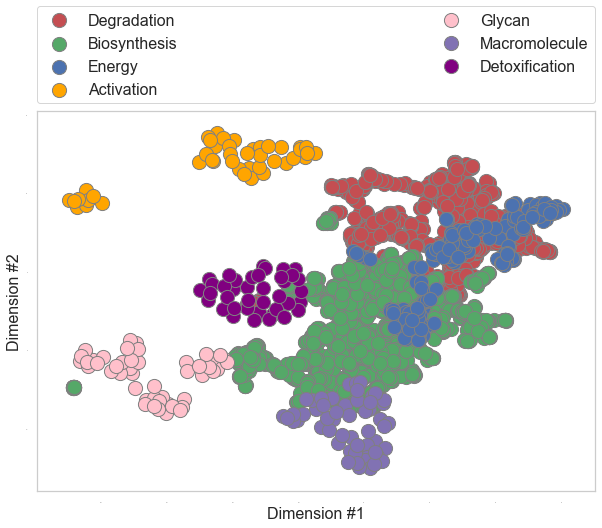

Figure for model name model6-100-100


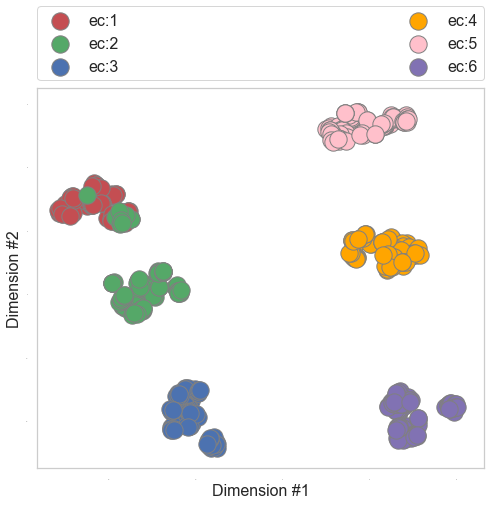

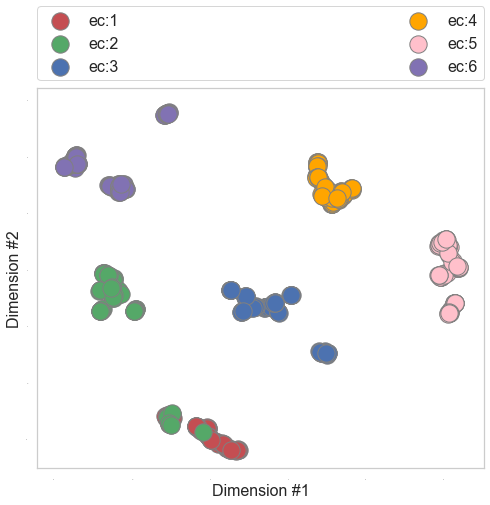

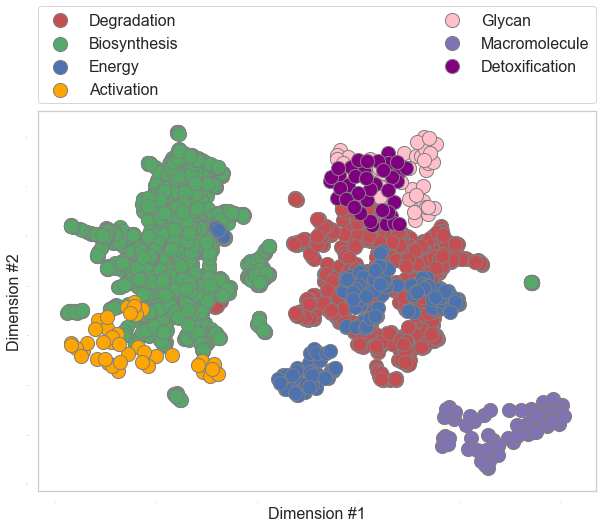

Figure for model name model6-100-200


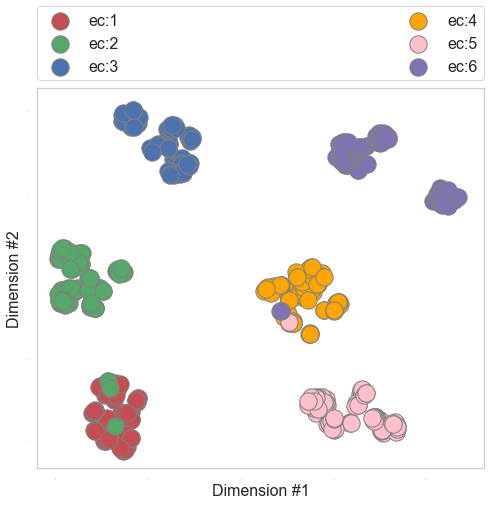

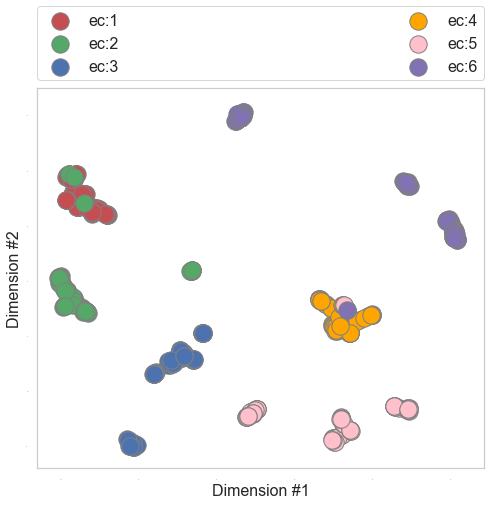

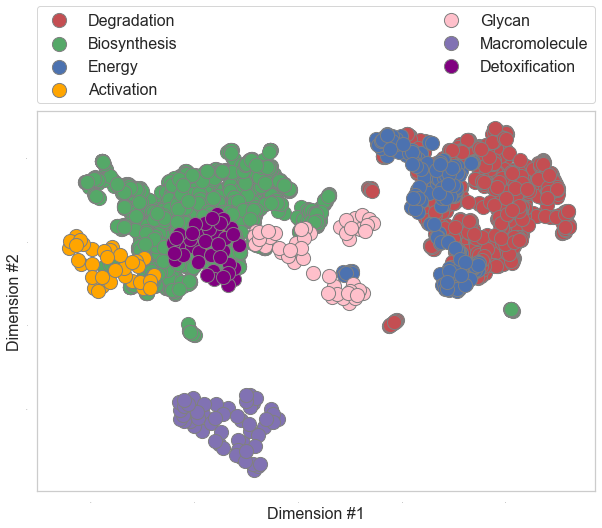

Figure for model name model6-100-300


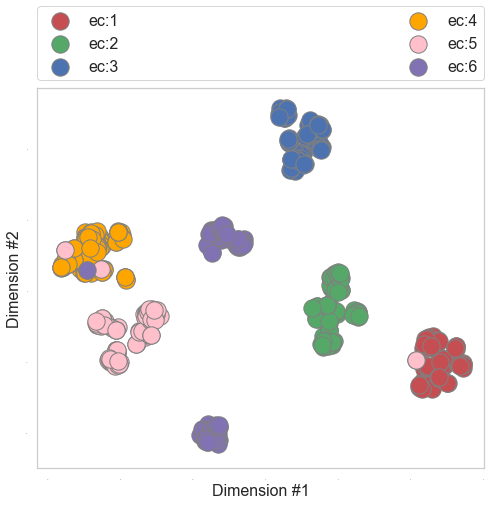

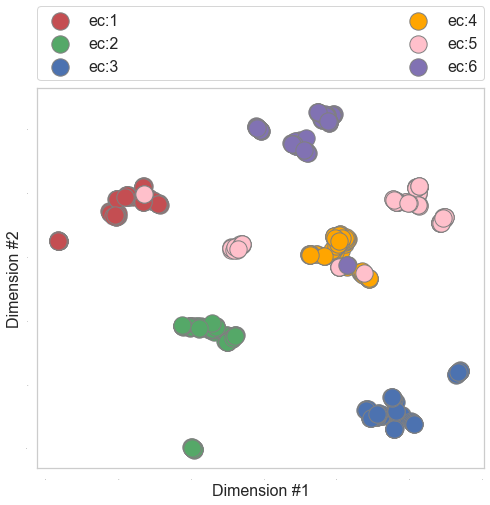

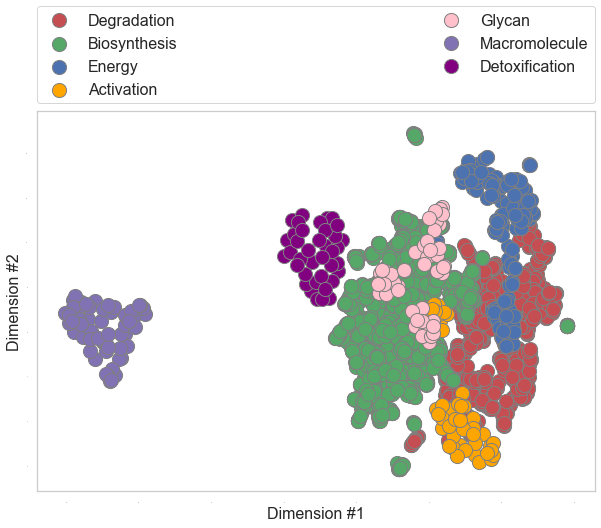

Figure for model name model6-1000-100


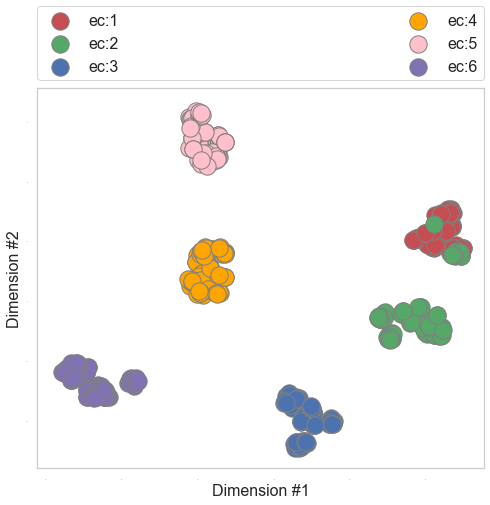

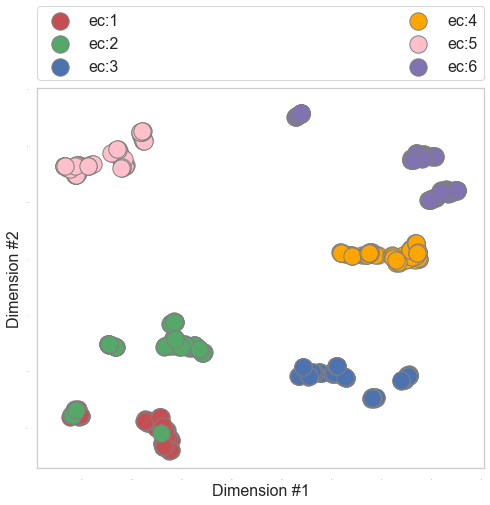

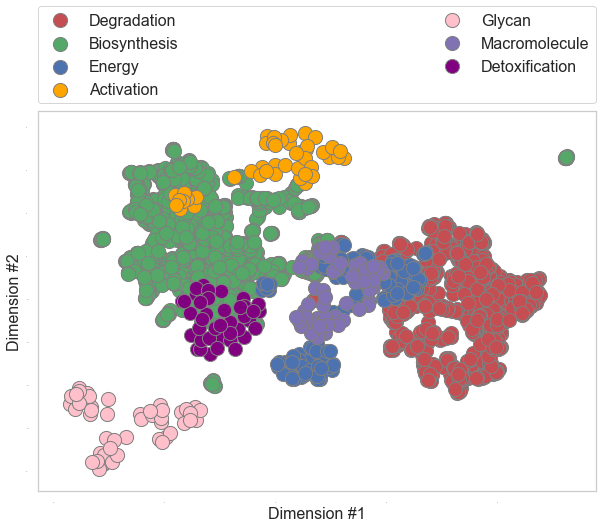

Figure for model name model6-1000-200


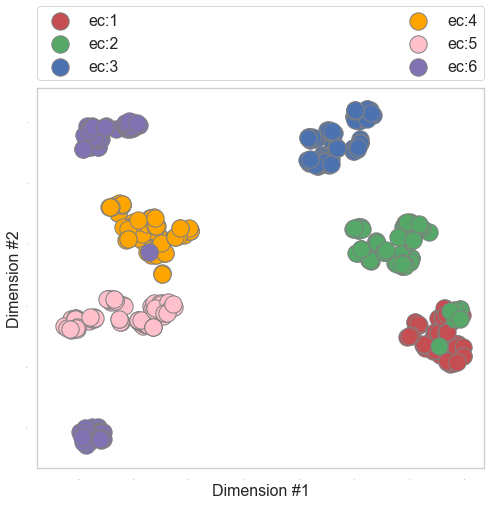

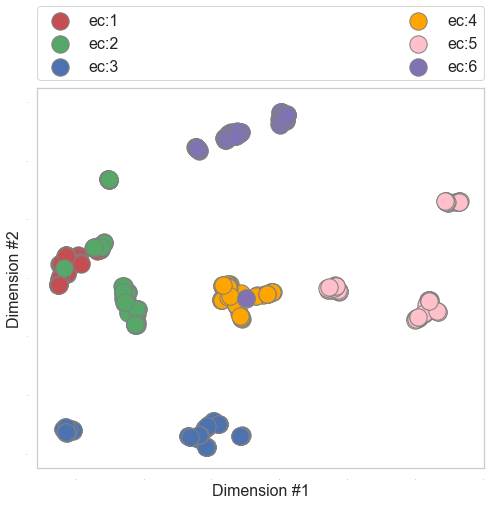

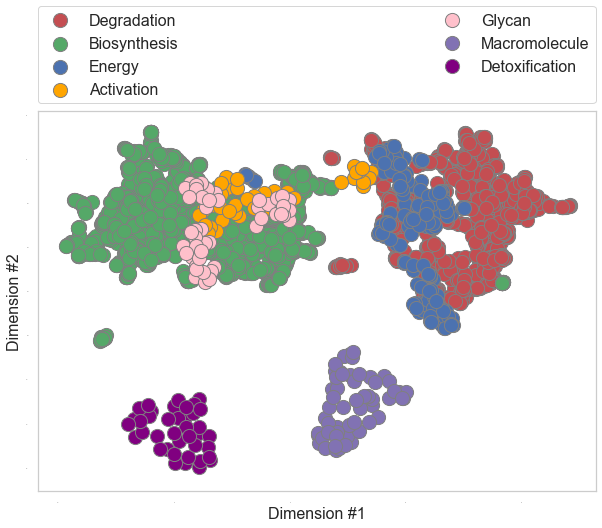

Figure for model name model6-1000-300


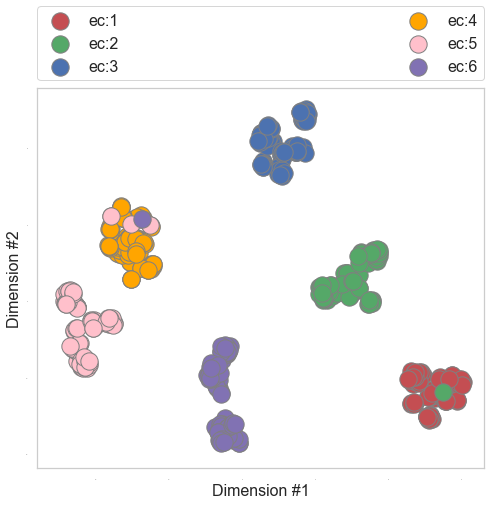

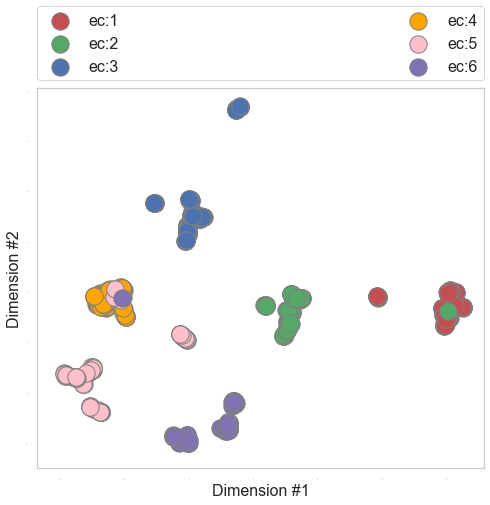

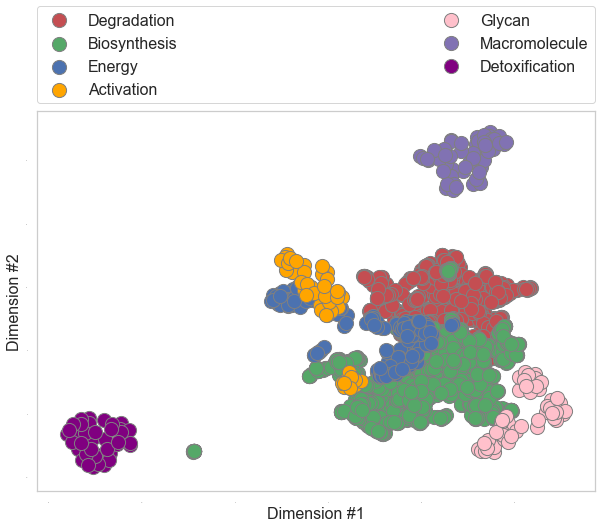

In [34]:
min_n=[3,4,5,6]
negative=[10,100,1000]
epochs=[100,200,300]
combined_list = min_n, negative, epochs
parameters=list(itertools.product(*combined_list))
for i,j in enumerate(parameters):
    name='model'+str(j[0])+'-'+str(j[1])+'-'+str(j[2])
    model=FT_gensim.load(models+name+".model")
    print("Figure for model name %s"%name)
    FT_ec_tsne(model)
    FT_ec_umap(model)
    plot_umap(cluster_df=dataM ,model_gensim=model,title_text=name);
    

In [30]:
import itertools
combined_list = min_n, negative, epochs
parameters=list(itertools.product(*combined_list))
for i,j in enumerate(parameters):
    name='model'+str(j[0])+'-'+str(j[1])+'-'+str(j[2])
    model=FT(epoch=j[2],EC_lists=EC,min_n=j[0],negative=j[1])
    model.save(Path+name+".model")
